In [1]:
import random
import math
import numpy as np
import os
import VisualizeNN as VisNN
from celluloid import Camera # getting the camera
import matplotlib.pyplot as plt
from IPython.display import HTML
from time import localtime, strftime


class Neuron():
    '''
        A conceptual Neuron hat can be trained using a 
        fit and predict methodology, without any library
    '''
    
    def __init__(self, position_in_layer, is_output_neuron=False, is_sigmoid=True):
        self.weights = []
        self.inputs = []
        self.output = None
        
        # This is used for the backpropagation update
        self.updated_weights = []
        # This is used to know how to update the weights
        self.is_output_neuron = is_output_neuron
        # This delta is used for the update at the backpropagation
        self.delta = None
        # This is used for the backpropagation update
        self.position_in_layer = position_in_layer 
        self.is_sigmoid = is_sigmoid
        
    def attach_to_output(self, neurons):
        '''
            Helper function to store the reference of the other neurons
            To this particular neuron (used for backpropagation)
        '''
        
        self.output_neurons = neurons
    
    def activation(self, x):
        if self.is_sigmoid:
            return self.sigmoid(x)
        else:
            #return self.Linear(x)
            return self.Relu(x)

    def activationDerive(self, x):
        if self.is_sigmoid:
            return self.sigmoidDerive(x)
        else:
            #return self.LinearDerive(x)
            return self.ReluDerive(x)
    
    def sigmoid(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return 1 / (1 + math.exp(-x))

    def sigmoidDerive(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return x*(1-x)

    def Relu(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return x if x> 0  else 0

    def ReluDerive(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return 1 if x >0 else 0
    
    def Linear(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return x

    def LinearDerive(self, x):
        '''
            simple sigmoid function (logistic) used for the activation
        '''
        return 1
    
    def init_weights(self, num_input):
        '''
            This is used to setup the weights when we know how many inputs there is for
            a given neuron
        '''
        
        # Randomly initalize the weights
        for i in range(num_input+1):
            w=random.uniform(0,1)
            self.weights.append(w)
            self.updated_weights.append(w)
        
    def predict(self, row):
        '''
            Given a row of data it will predict what the output should be for
            this given neuron. We can have many input, but only one output for a neuron
        '''
        
        # Reset the inputs
        self.inputs = []
        
        # We iterate over the weights and the features in the given row
        activation = 0
        for weight, feature in zip(self.weights, row):
            self.inputs.append(feature)
            activation = activation + weight*feature
            
        self.output = self.activation(activation)
        return self.output
    
        
            
    def update_neuron(self):
        '''
            Will update a given neuron weights by replacing the current weights
            with those used during the backpropagation. This need to be done at the end of the
            backpropagation
        '''
        
        self.weights = []
        for new_weight in self.updated_weights:
            self.weights.append(new_weight)
    
    def calculate_update(self, learning_rate, target,batchSize):
        '''
            This function will calculate the updated weights for this neuron. It will first calculate
            the right delta (depending if this neuron is a ouput or a hidden neuron), then it will
            calculate the right updated_weights. It will not overwrite the weights yet as they are needed
            for other update in the backpropagation algorithm.
        '''
        derive = self.activationDerive(self.output)
        if self.is_output_neuron:
            # Calculate the delta for the output
            self.delta = (self.output - target[self.position_in_layer])*derive
        else:
            # Calculate the delta
            delta_sum = 0
            # this is to know which weights this neuron is contributing in the output layer
            cur_weight_index = self.position_in_layer 
            for output_neuron in self.output_neurons:
                delta_sum = delta_sum + (output_neuron.delta * output_neuron.weights[cur_weight_index])

            # Update this neuron delta
            self.delta = delta_sum*derive
            
        
        # Iterate over each weight and update them
        i=0
        for cur_weight, cur_input in zip(self.weights, self.inputs):
            self.updated_weights[i]-=(learning_rate*self.delta*cur_input)/batchSize
            i+=1

    def toString(self):
        print(self.weights)
         
class Layer():
    '''
        Layer is modelizing a layer in the fully-connected-feedforward neural network architecture.
        It will play the role of connecting everything together inside and will be doing the backpropagation 
        update.
    '''
    
    def __init__(self, num_neuron, is_output_layer = False, is_sigmoid=True):
        
        # Will create that much neurons in this layer
        self.is_output_layer = is_output_layer
        self.neurons = []
        for i in range(num_neuron):
            # Create neuron
            neuron = Neuron(i,  is_output_neuron=is_output_layer, is_sigmoid=is_sigmoid)
            self.neurons.append(neuron)
    
    def attach(self, layer):
        '''
            This function attach the neurons from this layer to another one
            This is needed for the backpropagation algorithm
        '''
        # Iterate over the neurons in the current layer and attach 
        # them to the next layer
        for in_neuron in self.neurons:
            in_neuron.attach_to_output(layer.neurons)
            
    def init_layer(self, num_input):
        '''
            This will initialize the weights of each neuron in the layer.
            By giving the right num_input it will spawn the right number of weights
        '''
        
        # Iterate over each of the neuron and initialize
        # the weights that connect with the previous layer
        for neuron in self.neurons:
            neuron.init_weights(num_input)
    
    def predict(self, row):
        '''
            This will calcualte the activations for the full layer given the row of data 
            streaming in.
        '''
        rowClone = row.copy()
        rowClone = np.append(rowClone, [1]) # need to add the bias
        activations = [neuron.predict(rowClone) for neuron in self.neurons]
        return activations

    def toString(self):
        for neuron in self.neurons:
            neuron.toString(); 
        
class MultiLayerPerceptron():
    '''
        We will be creating the multi-layer perceptron with only two layer:
        an input layer, a perceptrons layer and a one neuron output layer which does binary classification
    '''
    def __init__(self,  is_Classifier=True):
        
        random.seed(5)
        # Layers
        self.layers = []
                
        # Training parameters
        self.is_Classifier = is_Classifier
        
        
    def add_output_layer(self, num_neuron, is_sigmoid=True):
        '''
            This helper function will create a new output layer and add it to the architecture
        '''
        self.layers.insert(0, Layer(num_neuron, is_output_layer = True, is_sigmoid=is_sigmoid))
    
    def add_hidden_layer(self, num_neuron, is_sigmoid=True):
        '''
            This helper function will create a new hidden layer, add it to the architecture
            and finally attach it to the front of the architecture
        '''
        # Create an hidden layer
        hidden_layer = Layer(num_neuron, is_sigmoid=is_sigmoid)
        # Attach the last added layer to this new layer
        hidden_layer.attach(self.layers[0])
        # Add this layers to the architecture
        self.layers.insert(0, hidden_layer)
        
    def learn_layers(self, target,learning_rate,batchSize):
        '''
            Will update all the layers by calculating the updated weights and then updating 
            the weights all at once when the new weights are found.
        '''
        # Iterate over each of the layer in reverse order
        # to calculate the updated weights
        for layer in reversed(self.layers):
                           
            # Calculate update the hidden layer
            for neuron in layer.neurons:
                neuron.calculate_update(learning_rate, target,batchSize)  

    
    def update_layers(self):
        '''
            Will update all the layers by calculating the updated weights and then updating 
            the weights all at once when the new weights are found.
        '''

        # Iterate over each of the layer in normal order
        # to update the weights
        for layer in self.layers:
            for neuron in layer.neurons:
                neuron.update_neuron()
    
    def train(self, X, y,batchSize=100,epochs=40,learning_rate = 0.1,each=1000):
        '''
            Main training function of the neural network algorithm. This will make use of backpropagation.
            It will use stochastic gradient descent by selecting one row at random from the dataset and 
            use predict to calculate the error. The error will then be backpropagated and new weights calculated.
            Once all the new weights are calculated, the whole network weights will be updated
        '''

        
        num_row = len(X)
        num_feature = len(X[0]) # Here we assume that we have a rectangular matrix
        
        # Init the weights throughout each of the layer
        self.layers[0].init_layer(num_feature)
        camera =None
        fig= None
        for i in range(1, len(self.layers)):
            num_input = len(self.layers[i-1].neurons)
            self.layers[i].init_layer(num_input)
        
        

        # Launch the training algorithm
        #self.toString()
        for i in range(epochs):
            
            for j  in range(batchSize):
                # Stochastic Gradient Descent
                r_i = random.randint(0,num_row-1)
                row = X[r_i] # take the random sample from the dataset
                yhat = self.predict([row],True)[0]
                #print("ok")
                #print(yhat)
                target = y[r_i]
                #print(target)
                # Update the layers using backpropagation   
                self.learn_layers( target,learning_rate,batchSize)
            self.update_layers()
            # At every 100 iteration we calculate the error
            # on the whole training set
            if (i) % int(epochs/30) == 0:
                fig = self.visualize(fig=fig,epoch=i)
                if camera is None: camera= Camera(fig)# the camera gets our figure
                camera.snap()

            if (i) % each == 0:
                #self.toString()
               # print("Layer Last")
                #self.layers[len(self.layers)-1].toString()
                total_error = 0
                for r_i in range(num_row):
                    row = X[r_i]
                    yhat = self.predict([row],True)[0]
                    error = (y[r_i] - yhat)
                    total_error = total_error + error**2
                mean_error = total_error/num_row
                print(f"Iteration {i} with error = {mean_error}")
        animation = camera.animate()
        animation.save('animation'+ strftime("%Y%m%d_%H%M%S", localtime())+'.mp4')
        
        #HTML(animation.to_html5_video())
        #self.toString()
        return HTML(animation.to_html5_video())
        
    def predict(self, rows,withoutClassifier=False):
        '''
            Prediction function that will take a row of input and give back the output
            of the whole neural network.
        '''
        results =[]
        # Gather all the activation in the hidden layer
        for row in rows:
            activations = self.layers[0].predict(row)
        
            for i in range(1, len(self.layers)):
            #print("activations layer " + str(i))
            #print(activations)
                activations = self.layers[i].predict(activations)

            outputs = []

            for activation in activations:
                if self.is_Classifier and not withoutClassifier :
                    # Decide if we output a 1 or 0
                    if activation >= 0.5:
                        outputs.append(1.0)
                    else:
                        outputs.append(0.0)
                else:
                    outputs.append(activation)
            results.append(outputs)   
                           
        # We currently have only One output allowed
        return results
        
    def validate(self, rows,rowY):
        '''
            Prediction function that will take a row of input and give back the output
            of the whole neural network.
        '''
        total_error = 0
        num_row= len(rows)
        for r_i in range(num_row):
            row = rows[r_i]
            yhat = self.predict([row])[0]
            print( "prediction ",  yhat,"  reelle",rowY[r_i])
            error = (rowY[r_i] - yhat)
            total_error = total_error + error**2
        mean_error = total_error/num_row
        print(f"Validation error = {mean_error}")

    def toString(self):
        for i, layer in enumerate(self.layers):
            print("Layer"+str(i))
            layer.toString()
    def visualize(self,fig=None,epoch=0):
        network_structure=[len(self.layers[0].neurons[0].weights)-1]
        for layer in self.layers:
            network_structure.append( len(layer.neurons))
        network=VisNN.DrawNN(np.array(network_structure),self._coefs())
        return network.draw( fig= fig,epoch=epoch)
        
    def _coefs(self):
        weights=[]
        maxweight=0
        for layer in self.layers:
            _weights=[[] for i in range(len( layer.neurons[0].weights ) -1)] 
            for neuron in layer.neurons:
                for i,weight in enumerate(neuron.weights[:-1]):
                    if maxweight<weight:maxweight=weight
                    if maxweight<-weight:maxweight=-weight
        for layer in self.layers:
            _weights=[[] for i in range(len( layer.neurons[0].weights ) -1)] 
            for neuron in layer.neurons:
                for i,weight in enumerate(neuron.weights[:-1]):
                    _weights[i].append(weight/maxweight)
            weights.append(np.array(_weights))
        return weights
        


In [16]:
import random
import math
import numpy as np
import os

class Layer():
    '''
        Layer is modelizing a layer in the fully-connected-feedforward neural network architecture.
        It will play the role of connecting everything together inside and will be doing the backpropagation 
        update.
    '''
    
    def activation(x):
        if self.is_sigmoid:
            return self.sigmoid(x)
        else:
            return self.relu(x)
        
    def derivation(x):
        if self.is_sigmoid:
            return self.sigmoid_der(x)
        else:
            return self.relu_der(x)
        
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_der(x):
        return x*(1-x)
    
    def linear(x):
        return np.ones(np.shape(x))


    def linear_der(x):
        return np.fmin([2, 3, 4], 0)
    
    def relu(x):
        return np.fmin(x, 0)


    def relu_der(x):
        return np.where(x <= 0, 0, 1) 
    
    
    def __init__(self, num_neuron, is_output_layer = False, is_sigmoid=True):
        
        # Will create that much neurons in this layer
        self.is_output_layer = is_output_layer
        self.neurons = []
        self.num_neuron=num_neuron
        self.is_sigmoid=is_sigmoid
        if self.is_output_layer:
            self.weights=[]
       
    
    def attach(self, layer):
        '''
            This function attach the neurons from this layer to another one
            This is needed for the backpropagation algorithm
        '''
        # Iterate over the neurons in the current layer and attach 
        # them to the next layer
       
        self.output_layer=layer
            
    def init_layer(self, num_input):
        '''
            This will initialize the weights of each neuron in the layer.
            By giving the right num_input it will spawn the right number of weights
        '''
        
        # Iterate over each of the neuron and initialize
        # the weights that connect with the previous layer
        self.weights = np.random.random((self.num_neuron, num_input+1))
        self.update_weights = self.weights.copy()

    
    def predict(self, rows):
        '''
            This will calcualte the activations for the full layer given the row of data 
            streaming in.
        '''
        print(rows)
        rowClone = np.hstack((rows,np.ones((len(rows),1)))) 
        np.append(rowClone, [1]) # need to add the bias
        print(rowClone)
        print(self.weights);
        activations = np.matmul(self.weights, rowClone)
        self.output = self.activation(self.weights, activations)
        return self.output

    
    def calculate_update(learning_rate, err,batchSize):
        delta = np.multiply(err , self.activation_der(self.output))
        self.update_weights += np.dot(self.output.T, (learning_rate*delta)/batchSize)
        return np.dot(delta, self.weights.T)
            
    def update_weights():
        self.weights = self.update_weights.copy()
    
    
    def toString(self):
        print(self.weights); 
        
class MultiLayerPerceptron():
    '''
        We will be creating the multi-layer perceptron with only two layer:
        an input layer, a perceptrons layer and a one neuron output layer which does binary classification
    '''
    def __init__(self, is_Classifier=True):
        
        random.seed(5)
        # Layers
        self.layers = []
                
        # Training parameters
        self.is_Classifier = is_Classifier
        
        
    def add_output_layer(self, num_neuron, is_sigmoid=True):
        '''
            This helper function will create a new output layer and add it to the architecture
        '''
        self.layers.insert(0, Layer(num_neuron, is_output_layer = True, is_sigmoid=is_sigmoid))
    
    def add_hidden_layer(self, num_neuron, is_sigmoid=True):
        '''
            This helper function will create a new hidden layer, add it to the architecture
            and finally attach it to the front of the architecture
        '''
        # Create an hidden layer
        hidden_layer = Layer(num_neuron, is_sigmoid=is_sigmoid)
        # Attach the last added layer to this new layer
        hidden_layer.attach(self.layers[0])
        # Add this layers to the architecture
        self.layers.insert(0, hidden_layer)
        
    def learn_layers(self, err,learning_rate,batchSize):
        '''
            Will update all the layers by calculating the updated weights and then updating 
            the weights all at once when the new weights are found.
        '''
        # Iterate over each of the layer in reverse order
        # to calculate the updated weights

        for layer in reversed(self.layers):
             err= layer.calculate_update(learning_rate, err,batchSize)  

    
    def update_layers(self):
        '''
            Will update all the layers by calculating the updated weights and then updating 
            the weights all at once when the new weights are found.
        '''

        # Iterate over each of the layer in normal order
        # to update the weights
        for layer in self.layers:
            layer.update_weights()
    
    def train(self, X, y,batchSize=100,epochs=40,learning_rate = 0.1):
        '''
            Main training function of the neural network algorithm. This will make use of backpropagation.
            It will use stochastic gradient descent by selecting one row at random from the dataset and 
            use predict to calculate the error. The error will then be backpropagated and new weights calculated.
            Once all the new weights are calculated, the whole network weights will be updated
        '''

        
        num_row = len(X)
        num_feature = len(X[0]) # Here we assume that we have a rectangular matrix
        
        # Init the weights throughout each of the layer
        self.layers[0].init_layer(num_feature)
        for i in range(1, len(self.layers)):
            num_input = self.layers[i-1].num_neuron
            self.layers[i].init_layer(num_input)
        
        #self.toString()
        
        # Launch the training algorithm
        for i in range(epochs):
            
            # Stochastic Gradient Descent

            yhat = self.predict(X)
            #print("ok")
            #print(yhat)
            target = y
            #print(target)
            # Update the layers using backpropagation   
            
            self.learn_layers( target-yhat,learning_rate,num_row)
            self.update_layers()
            # At every 100 iteration we calculate the error
            # on the whole training set
            
            print("Layer Last")
            self.layers[len(self.layers)-1].toString()
            total_error = 0

            for r_i in range(num_row):
                row = X[r_i]
                yhat = self.predict([row])[0]
                error = (y[r_i] - yhat)
                total_error = total_error + error**2
            mean_error = total_error/num_row
            print(f"Iteration {i} with error = {mean_error}")
                
        #self.toString()
        
    
    def predict(self, rows):
        '''
            Prediction function that will take a row of input and give back the output
            of the whole neural network.
        '''
        results =[]
        # Gather all the activation in the hidden layer
        activations = self.layers[0].predict(rows)
        
        for i in range(1, len(self.layers)):
            #print("activations layer " + str(i))
            #print(activations)
            activations = self.layers[i].predict(activations)

        if self.is_Classifier :
            activations = np.where(activations >=0.5,1,0)
           
        return activations
        
    def validate(self, rows,rowY):
        '''
            Prediction function that will take a row of input and give back the output
            of the whole neural network.
        '''
        total_error = 0
        num_row= len(rows)
        for r_i in range(num_row):
            row = rows[r_i]
            yhat = self.predict([row])[0]
            print( "prediction ",  yhat,"  reelle",rowY[r_i])
            error = (rowY[r_i] - yhat)
            total_error = total_error + error**2
        mean_error = total_error/num_row
        print(f"Validation error = {mean_error}")


    
    def toString(self):
        for i, layer in enumerate(self.layers):
            print("Layer"+str(i))
            layer.toString()


In [17]:
# XOR function (one or the other but not both)
X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([[0], [1], [1], [0]])

# Init the parameters for the network
clf = MultiLayerPerceptron(  is_Classifier=True )
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=True)
#clf.add_hidden_layer(num_neuron = 3)
clf.add_hidden_layer(num_neuron = 2, is_sigmoid=True)
# Train the network
clf.train(X,y,learning_rate = 1,batchSize=4,epochs=2000)
#clf.visualize()



[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[[0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]]
[[0.33922524 0.78853535 0.29794708]
 [0.46191293 0.76019647 0.49447466]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [6]:
#[array([[-0.19128529,  0.52769418],
#       [-1.21246978, -0.47219728]]), array([[-0.87539714],
#       [-0.4248346 ]])]

print(clf._coefs())

[array([[0.48701053, 1.        ],
       [0.66069729, 0.79598295]]), array([[-0.45377305],
       [ 0.1352808 ]])]


In [3]:
print("Expected 0.0, got: ",clf.predict([[0,0]]))
print("Expected 1.0, got: ",clf.predict([[0,1]]))
print("Expected 1.0, got: ",clf.predict([[1,0]]))
print("Expected 0.0, got: ",clf.predict([[1,1]]))


Expected 0.0, got:  [[0.0]]
Expected 1.0, got:  [[1.0]]
Expected 1.0, got:  [[1.0]]
Expected 0.0, got:  [[0.0]]


Iteration 0 with error = [0.19182479]
Iteration 1000 with error = [0.11213132]
Iteration 2000 with error = [0.05974433]
Iteration 3000 with error = [0.05154606]
Iteration 4000 with error = [0.01882818]
Iteration 5000 with error = [0.00215894]
Iteration 6000 with error = [5.31177055e-05]
Iteration 7000 with error = [1.2073975e-06]
Iteration 8000 with error = [1.55097496e-08]
Iteration 9000 with error = [3.24911713e-10]
Iteration 10000 with error = [4.90635899e-12]
Iteration 11000 with error = [8.81922088e-14]
Iteration 12000 with error = [2.47779505e-15]
Iteration 13000 with error = [2.71943252e-17]
Iteration 14000 with error = [1.32754198e-18]
Iteration 15000 with error = [1.8906116e-20]
Iteration 16000 with error = [7.58662921e-22]
Iteration 17000 with error = [4.32935937e-24]
Iteration 18000 with error = [6.44073375e-26]
Iteration 19000 with error = [1.21385972e-27]


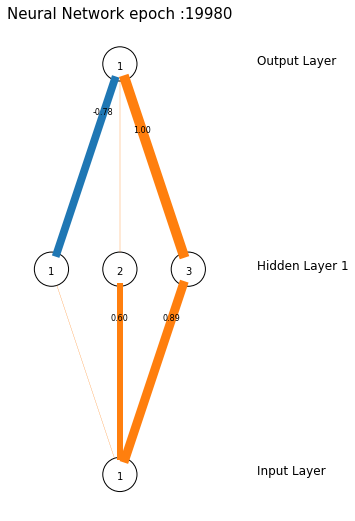

In [4]:
import numpy as np
# 1. Creation of test data set

X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      [2],
      [3],
      [2.5]
])


# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier=False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 3, is_sigmoid=True)
# Train the network
clf.train(X,Y,learning_rate = 0.2,batchSize=3,epochs=20000)




In [5]:
print("Expected 2, got: ",clf.predict([[1],[4]]))
print("Expected 3, got: ",clf.predict([[2]]))
print("Expected 2.5, got: ",clf.predict([[3]]))

Expected 2, got:  [[2.0000000000000013], [2.0938070846130006]]
Expected 3, got:  [[2.999999999999995]]
Expected 2.5, got:  [[2.500000000000006]]


Iteration 0 with error = [0.25052381 1.00719715]
Iteration 1000 with error = [0.05803887 0.22088588]
Iteration 2000 with error = [0.01267136 0.04487933]
Iteration 3000 with error = [6.64040923e-05 1.59716540e-04]
Iteration 4000 with error = [8.02423432e-08 1.95934262e-08]
Iteration 5000 with error = [6.91679652e-10 1.46832240e-10]
Iteration 6000 with error = [1.13602284e-11 2.81556376e-12]
Iteration 7000 with error = [2.07036047e-13 5.18374003e-14]
Iteration 8000 with error = [5.46493299e-15 1.37367737e-15]
Iteration 9000 with error = [1.70799930e-16 4.26809368e-17]


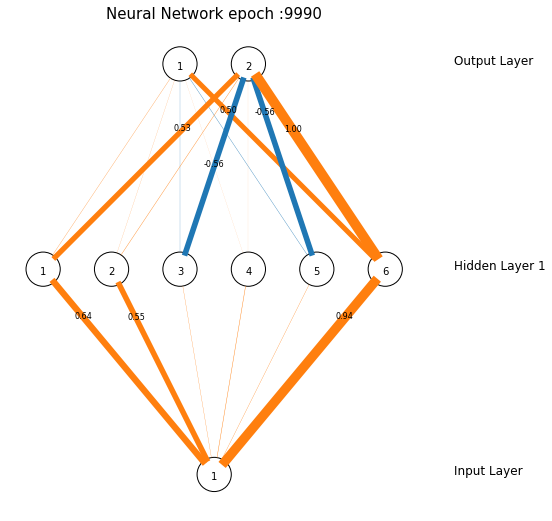

In [9]:
import numpy as np
# 1. Creation of test data set

X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      [2,4],
      [3,6],
      [2.5,5]
])


# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier=False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 2, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 6, is_sigmoid=True)
# Train the network
clf.train(X,Y,learning_rate = 0.2,batchSize=3,epochs=10000)


In [7]:

print("Expected 2, got: ",clf.predict([[1],[4]]))
print("Expected 3, got: ",clf.predict([[2]]))
print("Expected 2.5, got: ",clf.predict([[3]]))

Expected 2, got:  [[2.0, 4.0], [2.1309492735801805, 4.259724806836254]]
Expected 3, got:  [[3.0, 6.0]]
Expected 2.5, got:  [[2.5000000000000004, 4.999999999999999]]


Expected 2, got:  [[0, 0]]
Expected 3, got:  [[0, 0]]
Expected 2.5, got:  [[0, 0]]
Iteration 0 with error = [0.85710756 6.18528574]
Iteration 1000 with error = [0.02195058 0.00125427]
Iteration 2000 with error = [5.60187106e-04 2.08852698e-05]
Iteration 3000 with error = [4.13008058e-05 1.70787491e-06]
Iteration 4000 with error = [2.63102301e-06 1.16219068e-07]


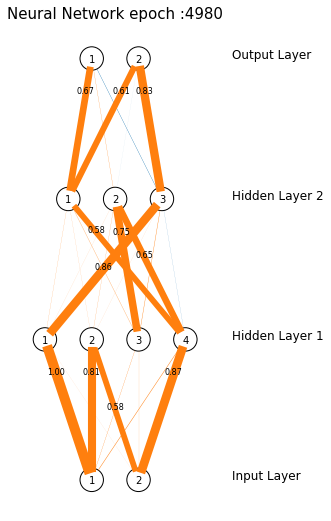

In [10]:
# 1. Creation of test data set

X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      [2,3],
      [3,5],
      [2.5,6]
])

# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 2, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 3, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 4, is_sigmoid=False)
# Train the network
print("Expected 2, got: ",clf.predict([[1, 1]]))
print("Expected 3, got: ",clf.predict([[2, 2]]))
print("Expected 2.5, got: ",clf.predict([[3, 1]]))
clf.train(X,Y,learning_rate = 0.01,batchSize=3,epochs=5000)



Iteration 0 with error = [51.23664494]
Iteration 1000 with error = [2.43795469]
Iteration 2000 with error = [2.42161625]
Iteration 3000 with error = [2.40368296]
Iteration 4000 with error = [2.38014516]
Iteration 5000 with error = [2.3490688]
Iteration 6000 with error = [2.1716623]
Iteration 7000 with error = [1.89711065]
Iteration 8000 with error = [1.60153733]
Iteration 9000 with error = [1.51085547]
Iteration 10000 with error = [1.50104902]
Iteration 11000 with error = [1.5000036]


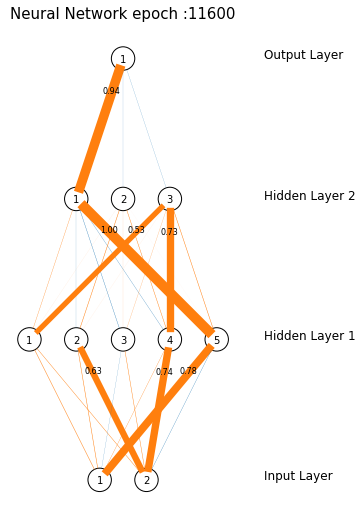

In [11]:
# 1. Creation of test data set

X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
     [ 2],
      [1],
      [-2],
      [-1]
])
# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 3, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 5, is_sigmoid=False)
# Train the network
clf.train(X,Y,learning_rate = 0.001,batchSize=4,epochs=12000)


In [12]:
print("Expected 2, got: ",clf.predict([[1, 0]]))
print("Expected 1, got: ",clf.predict([[0, 1]]))
print("Expected -2, got: ",clf.predict([[1, 1]]))
print("Expected -1, got: ",clf.predict([[0, 0]]))

Expected 2, got:  [[1.999900903767949]]
Expected 1, got:  [[0]]
Expected -2, got:  [[0]]
Expected -1, got:  [[0]]


Iteration 0 with error = [0.60302104]
Iteration 1000 with error = [0.01450429]


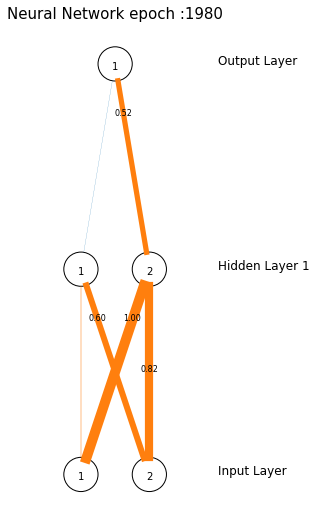

In [13]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 3]
])
Y = np.array([
      [1],
      [2],
      [3]
])
# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
#clf.add_hidden_layer(num_neuron = 2, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 2, is_sigmoid=False)
# Train the network
clf.train(X,Y,learning_rate = 0.01,batchSize=3,epochs=2000)



In [ ]:
print("Expected 1, got: ",clf.predict([[1, 1]]))
print("Expected 2, got: ",clf.predict([[2, 2]]))
print("Expected 3, got: ",clf.predict([[3, 3]]))

Iteration 0 with error = [1.]
Iteration 1000 with error = [1.]
Iteration 2000 with error = [1.]
Iteration 3000 with error = [1.]
Iteration 4000 with error = [1.]
Iteration 5000 with error = [1.]
Iteration 6000 with error = [1.]
Iteration 7000 with error = [1.]
Iteration 8000 with error = [1.]
Iteration 9000 with error = [1.]


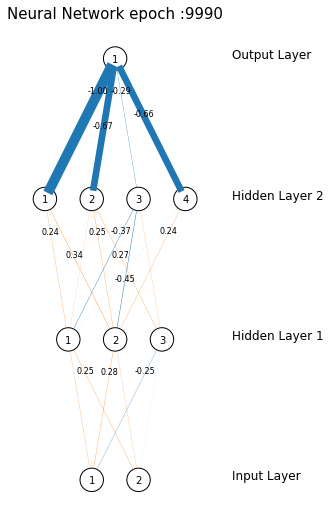

In [3]:
#GOOD
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])
# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier = False)
# Create the architecture backward
clf.add_output_layer(num_neuron = 1, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 4, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 3, is_sigmoid=False)
# Train the network
clf.train(X,Y,learning_rate = 0.06, epochs = 10000)


In [12]:
#TEST
np.ones(np.shape([[2,4,7],[3,7,8]]))

array([[1., 1., 1.],
       [1., 1., 1.]])

In [132]:
from tqdm import tqdm
from PIL import Image, ImageOps 
import matplotlib.pyplot as plt
import matplotlib.image as img


def preprocess_dataset(paths, img_size):
    list_X, list_Y ,images = [], [],[]
    for path in paths:
        images = images+ [path + "/" + i  for i in os.listdir(path) ] 
    np.random.shuffle(images)
    
    for filename in tqdm(images):
        if "." in filename:
            img = ImageOps.grayscale(Image.open(filename).resize(img_size))
            array = np.asarray(img).flatten().tolist()

            #plt.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
            #plt.show()
            list_X.append(array)

            if "pizza" in filename:
                class_array =[1,0,0]
            elif "tarte aux pommes" in filename:
                class_array =[0,1,0]
            elif "tarte aux fraises" in filename:
                class_array =[0,0,1]

            list_Y.append(class_array)

    X, Y = np.array(list_X), np.array(list_Y)
    return X / 255. ** 2, Y


In [133]:

X, Y = preprocess_dataset(["dataset/train/pizza",
                          "dataset/train/tarte aux pommes",
                         "dataset/train/tarte aux fraises"],
                          (64, 64))


# Init the parameters for the network
clf = MultiLayerPerceptron( is_Classifier = True)
# Create the architecture backward

clf.add_output_layer(num_neuron = 3, is_sigmoid=True)
clf.add_hidden_layer(num_neuron = 512, is_sigmoid=False)
clf.add_hidden_layer(num_neuron = 512, is_sigmoid=False)

# Train the network
clf.train(X,Y,batchSize=20,epochs=4000,learning_rate =0.1,each=1)

100%|██████████| 310/310 [00:00<00:00, 1524.47it/s]


KeyboardInterrupt: 

In [ ]:
Xtest, Ytest = preprocess_dataset(["dataset/test/pizza",
                          "dataset/test/tarte aux pommes",
                         "dataset/test/tarte aux fraises"],
                          (64, 64))
clf.validate(Xtest,Ytest)

In [135]:

def preprocess_dataset2(paths, img_size):
    list_X, list_Y ,images = [], [],[]
    for path in paths:
        images = images+ [path + "/" + i  for i in os.listdir(path) ] 
    np.random.shuffle(images)
    
    for filename in tqdm(images):
        if "." in filename:
            img = ImageOps.grayscale(Image.open(filename).resize(img_size))
            array = np.asarray(img)#.flatten().tolist()

            #plt.imshow(img, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
            #plt.show()
            list_X.append(array)

            if "pizza" in filename:
                class_array =0
            elif "tarte aux pommes" in filename:
                class_array =1
            elif "tarte aux fraises" in filename:
                class_array =2

            list_Y.append(class_array)

    X, Y = np.array(list_X), np.array(list_Y)
    return X / 255. ** 2, Y

100%|██████████| 69/69 [00:00<00:00, 1806.29it/s]


Training data shape :  (310, 64, 64) (310,)
Testing data shape :  (69, 64, 64) (69,)
Total number of outputs :  3
Output classes :  [0 1 2]


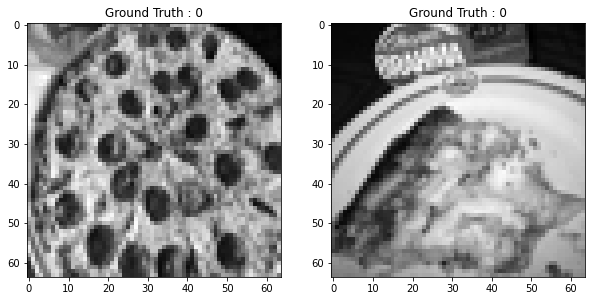

In [136]:


train_images, train_labels = preprocess_dataset2(["dataset/train/pizza",
                          "dataset/train/tarte aux pommes",
                         "dataset/train/tarte aux fraises"],
                          (64, 64))

test_images, test_labels = preprocess_dataset2(["dataset/test/pizza",
                          "dataset/test/tarte aux pommes",
                         "dataset/test/tarte aux fraises"],
                          (64, 64))

print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
classes_num = len(classes)
print('Total number of outputs : ', classes_num)
print('Output classes : ', classes)

plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

# Change from matrix to array of dimension 28x28 to array of dimension 784
dim_data = np.prod(train_images.shape[1:])
train_data = train_images.reshape(train_images.shape[0], dim_data)
test_data = test_images.reshape(test_images.shape[0], dim_data)

# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')


In [ ]:

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
if False:
# Change the labels from integer to categorical data
    train_labels_one_hot = to_categorical(train_labels)
    test_labels_one_hot = to_categorical(test_labels)




    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(dim_data,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes_num, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#history = model.fit(train_data, train_labels_one_hot, batch_size=20, epochs=20, verbose=1, validation_data=(test_data, test_labels_one_hot))

#[test_loss, test_acc] = model.evaluate(test_data, test_labels_one_hot)
#print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))


In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) plt.plot(history.history['accuracy'],'r',linewidth=3.0) plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) plt.xlabel('Epochs ',fontsize=16) plt.ylabel('Accuracy',fontsize=16) plt.title('Accuracy Curves',fontsize=16)

In [ ]:

# this function takes any model and evaluates it against both training set and dataset
# it prints the following:
#  1. Accuracy Score against trainning set
#  2. Classification report against training set
#  3. Accuracy Score against test set
#  4. Classification report against test set
#  5. Confusion matrix against test set

# metrics import
%matplotlib inline
import seaborn as sns 
sns.set()
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def evaluate_model(name, model,X_test, y_test,X_train,y_train,labels):
    # predict using the trained model against training dataset
    y_predict_train = model.predict(X_train)
    
    # predict using the trained model against test dataset
    y_predict_test = model.predict(X_test)
    
    print("Evaluating Model: " + name)
    print("")
    
    print("1. Accuracy Score (training set) for " + name)

    print(accuracy_score(y_train, y_predict_train))
    print("")
    
    print("2. Classification Report (training set) for " + name)
    print(classification_report(y_train, y_predict_train))
    print("")

    print("3. Accuracy Score (test set) for " + name)
    print(accuracy_score(y_test, y_predict_test))
    print("")

    print("4. Classification Report (test set) for " + name)
    print(classification_report(y_test, y_predict_test))
    print("")
    
    print("5. Confusion Matrix for model: " + name)
    cmap = sns.cubehelix_palette(light= 0.9, as_cmap=True)
    cm = confusion_matrix(y_test, y_predict_test)
    sns.heatmap(cm.T, square = True, annot=True, fmt='d', cbar=False,
               xticklabels=labels,
               yticklabels=labels, cmap=cmap)
    
    plt.xlabel('True label', size=12)
    plt.ylabel('Predicted label', size=12)
    plt.title('Confusion matrix for model: ' + name)
   

In [ ]:
X

In [ ]:
Xtest, Ytest = preprocess_dataset(["dataset/test/pizza",
                          "dataset/test/tarte aux pommes",
                         "dataset/test/tarte aux fraises"],
                          (32, 32))
evaluate_model("MLP Classifier ", clf,Xtest, Ytest,X,Y,["pizza",
                          "tarte aux pommes",
                         "tarte aux fraises"])

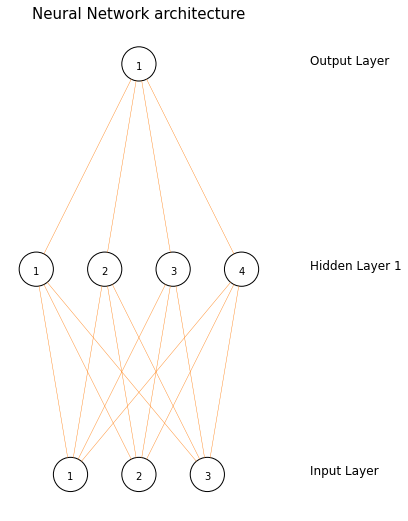

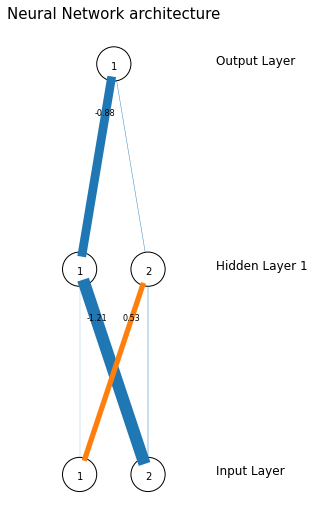

In [61]:
import VisualizeNN as VisNN
from sklearn.neural_network import MLPClassifier
import numpy as np

training_set_inputs = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 1], [0, 0, 0]])
training_set_outputs = np.array([[0, 1, 1, 1, 1, 0, 0]]).T

training_set_inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
training_set_outputs = np.array([[0, 1, 1,  0]]).T

X = training_set_inputs
y = training_set_outputs

classifier = MLPClassifier(hidden_layer_sizes=(2,), alpha=0.01, tol=0.001, random_state=1)
classifier.fit(X, y.ravel())

network_structure = np.hstack(([X.shape[1]], np.asarray(classifier.hidden_layer_sizes), [y.shape[1]]))

# Draw the Neural Network with weights
network=VisNN.DrawNN(network_structure, classifier.coefs_)
network.draw()




In [63]:

print(classifier.coefs_)

[array([[-0.19128529,  0.52769418],
       [-1.21246978, -0.47219728]]), array([[-0.87539714],
       [-0.4248346 ]])]


In [62]:
network_structure

array([2, 2, 1])